#Notebook: Basic operations
##Author: Lucía Núñez Calvo
###Date: 28/03/2024

####Summary
This notebook will be used to perform the first operations on audio files.
First of all, the wave spectrum of some of the audios will be represented in order to be able to check at a glance in which moments of time a higher amplitude is obtained.
Then we will create some audio clips that are too long for their visual classification. This action is done in order to be able to clearly observe in which seconds of the audio the sounds of higher amplitude are being emitted.
Finally, the dataset that has been manually created for the classification of the sounds will be shown, in which a 0 appears if the baby is crying and a 1 if what is heard in the audio is not the baby's cry.


####Structure of the notebook

0.   Installations
1.   Main problem
2.   Audio representation
3.   Clip creation
4.   Data set with labels


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os
import ast # In this case, to convert a text string to a Python list
import numpy as np
import pandas as pd
from pydub import AudioSegment
import matplotlib.pyplot as plt

### 0. Installations

In [2]:
pip install pydub

###1. Main problem

The first approach of this project was to observe the wavefrom representation of some audios in which the main sounds were babies crying and other audios in which the main sounds were background noises or medical personnel sharing guidelines with each other. In this way, a problem in recognising crying with the naked eye was observed. The wavefrom of audios with crying and the wavefrom of audios with sounds other than crying are practically impossible to recognise with the naked eye, because the graph visualises the amplitude of the sound, but sometimes the comments of the medical staff may have a greater amplitude than the crying of the newborn.


In order to visually demonstrate this event, two audios have been selected, one of which only shows the cries of a baby, while the other audio shows different sounds such as a large background noise and comments from health personnel about the baby's condition.

In [2]:
#Path to the directory that stores the audio of a baby in which only cries are heard.
path_baby_crying = 'drive/MyDrive/TFM/Audios/Unclassified/IMG_0927.wav'

#Path to the directory that stores the audio of a baby in which both cries and other noises are heard, in this case, different communications between health workers.
path_noise = 'drive/MyDrive/TFM/Audios/Unclassified/IMG_2841.wav'

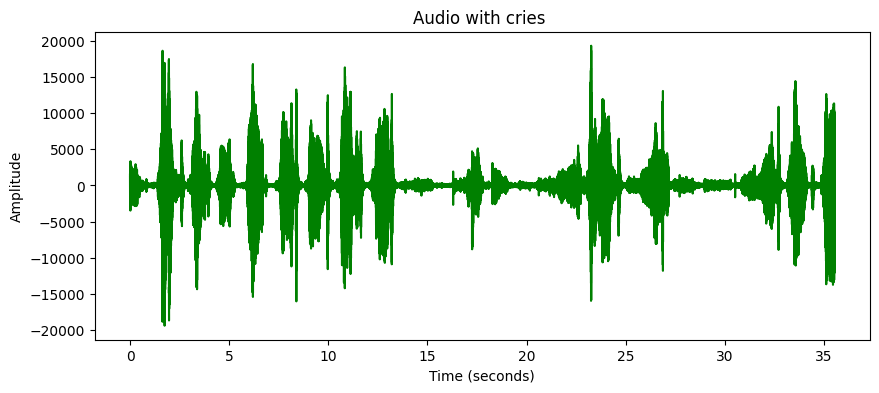

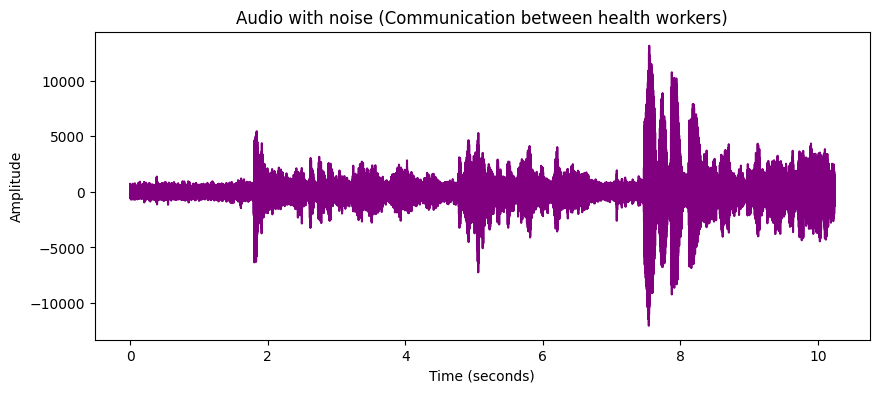

In [12]:
def plot_audio(audio_path, title, color):
    '''
    This function allows the waveform representation of the audio that is passed by parameter.

    Input:
      - audio_path: (str) The path of the video to be shown.
      - title: (str) The title to be displayed in the graph.
      - color: (str) Color of the waveform line.
    '''

    # Load audio file using pydub
    audio = AudioSegment.from_file(audio_path)

    # Create an amplitude value matrix of the audio data
    data = np.array(audio.get_array_of_samples())

    # Creation of the time axis to be displayed on the chart
    start = 0
    stop = len(audio) / 1000.0 # Total duration of the file given in milliseconds, and transformed to seconds.
    time = np.linspace(start, stop, num=len(data))

    plt.figure(figsize=(10, 4))
    plt.plot(time, data, color=color)
    plt.title(title)
    plt.xlabel('Time (seconds)')
    plt.ylabel('Amplitude')
    plt.show()

plot_audio(path_baby_crying, 'Audio with cries ', 'green')
plot_audio(path_noise, 'Audio with noise (Communication between health workers)', 'purple')

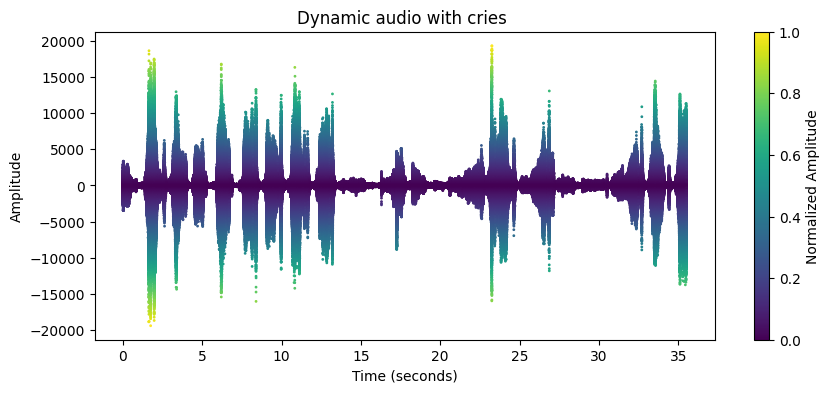

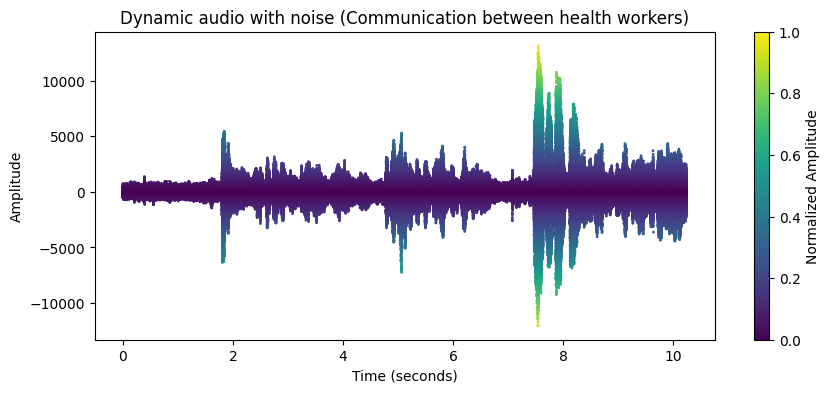

In [5]:
def plot_audio_amplitude(audio_path, title):
    '''
    This function allows the waveform representation of the audio that is passed by parameter.
    The difference with this function is that it provides different colours depending on the amplitude of the sound.

    Input:
      - audio_path: (str) The path of the video to be shown.
      - title: (str) The title to be displayed in the graph.
    '''
    # Load audio file using pydub
    audio = AudioSegment.from_file(audio_path)

    # Create an amplitude value matrix of the audio data
    data = np.array(audio.get_array_of_samples())

    # Creation of the time axis to be displayed on the chart
    start = 0
    stop = len(audio) / 1000.0 # Total duration of the file given in milliseconds, and transformed to seconds.
    time = np.linspace(start, stop, num=len(data))

    # Normalise amplitude data
    normalized_amplitude = np.abs(data) / np.max(np.abs(data))

    # Define amplitude threshold to change the colour of the waveform
    values = 0.1 + 0.9 * (normalized_amplitude > np.percentile(normalized_amplitude, 50))

    plt.figure(figsize=(10, 4))
    scatter = plt.scatter(time, data, c=normalized_amplitude, cmap='viridis', alpha=values, s=1)
    plt.colorbar(scatter, label='Normalized Amplitude')
    plt.title(title)
    plt.xlabel('Time (seconds)')
    plt.ylabel('Amplitude')

    # Save the graph
    file_name = os.path.splitext(os.path.basename(audio_path))[0] # Extracts the filename without the file extension
    output_filename = f"{file_name}.png"
    output_path = os.path.join(audio_path, output_filename)
    plt.savefig(output_path)

    plt.show()

plot_audio_amplitude(path_baby_crying, 'Dynamic audio with cries ')
plot_audio_amplitude(path_noise, 'Dynamic audio with noise (Communication between health workers)')

**Looking at the above results, it can be seen that at first glance it is not possible to identify whether the sound in the audio is that of a baby crying or some other kind of noise.**


###2. Audio representation

The main objective of this project is to correctly detect whether or not the baby is reacting to an external stimulus by means of audio analysis. For this reason, the results obtained on the audios classified as:
- *No encephalopathy*, the baby will cry normally.
- *Mild encephalopathy*, the baby will cry.
- *Moderate encephalopathy*, the baby will cry less than expected.
- *Severe encephalopathy*, the baby will not cry.

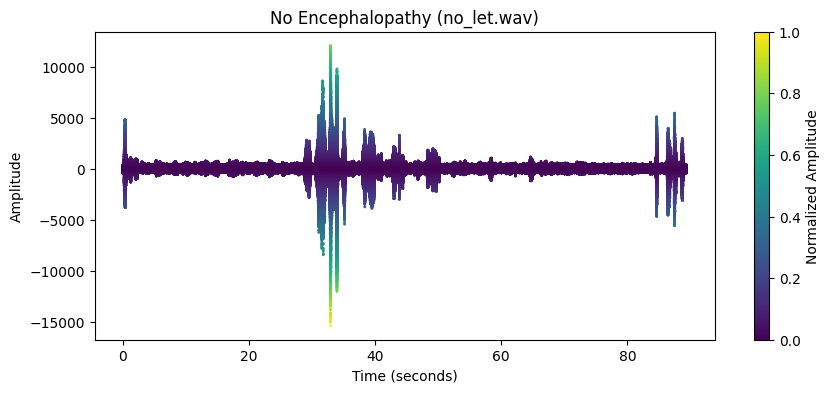

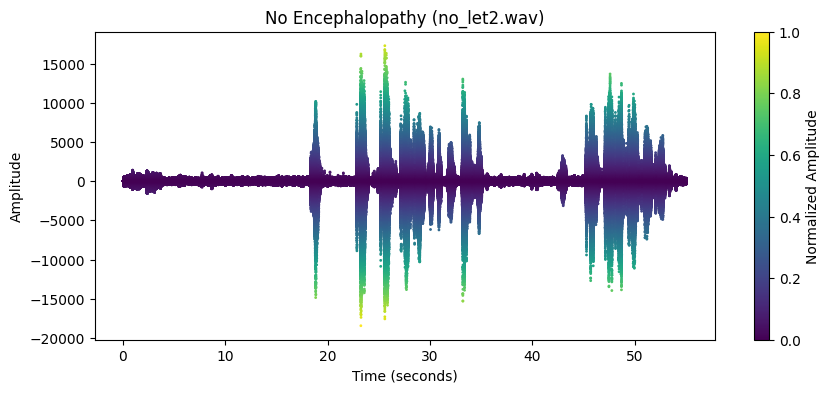

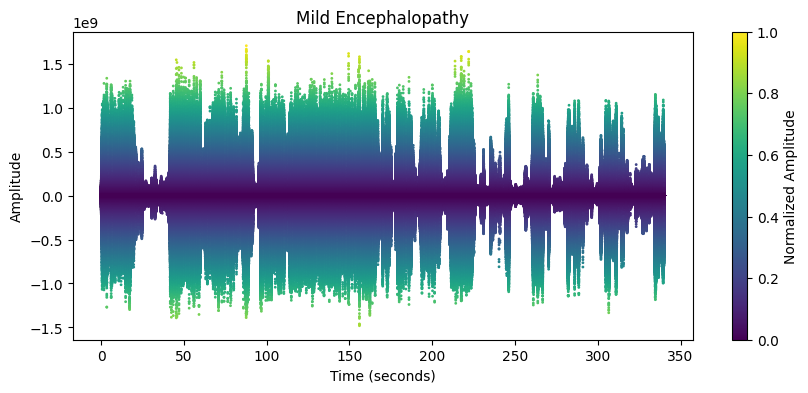

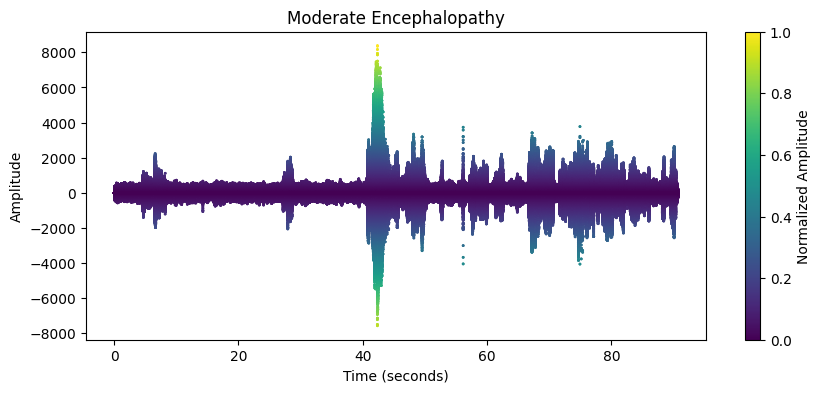

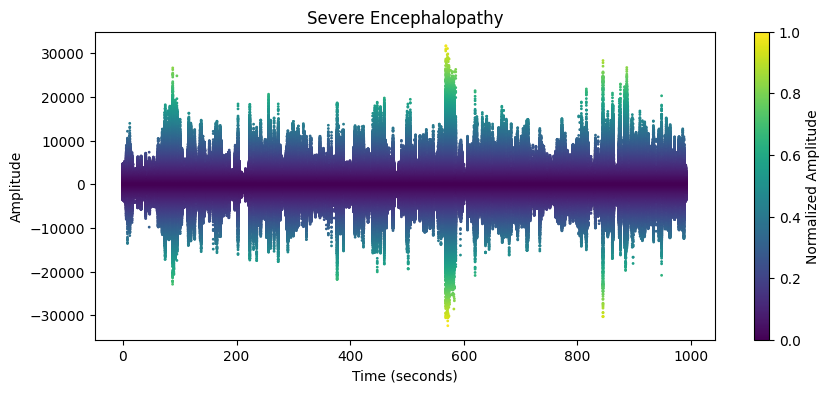

In [12]:
plot_audio_amplitude('drive/MyDrive/TFM/Audios/No_encephalopathy/no_let.wav', 'No Encephalopathy (no_let.wav)')
plot_audio_amplitude('drive/MyDrive/TFM/Audios/No_encephalopathy/no_let2.wav', 'No Encephalopathy (no_let2.wav)')
plot_audio_amplitude('drive/MyDrive/TFM/Audios/Mild_encephalopathy/ARAHIP1H12082011.wav', 'Mild Encephalopathy')
plot_audio_amplitude('drive/MyDrive/TFM/Audios/Moderate_encephalopathy/let.wav', 'Moderate Encephalopathy')
plot_audio_amplitude('drive/MyDrive/TFM/Audios/Severe_encephalopathy/ARAHIP_08062011_1hora.wav', 'Severe Encephalopathy')

###3. Clip creation

As can be seen in the above representations, some audios are quite long, which makes it difficult to classify at a glance the seconds in which the audio is longest.

To solve this problem, the audio has been trimmed, specifically the '*mild encephalopathy*' audio, because the severe encephalopathy audio is an audio in which baby cries are not heard.

In order to make clips of each stimulus, the entire video was viewed and the times at which a stimulus begins and ends were noted in order to create the clips. It has been observed that the stimuli take place in the following time instants.


*   [0:00 - 0:40]  -->  No stimulus
*   [0:41 - 0:54]  -->  Stimulus 1
*   [0:55 - 1:14]  -->  Stimulus 2
*   [1:15 - 1:36]  -->  Stimulus 3
*   [1:37 - 2:06]  -->  Stimulus 4
*   [2:07 - 2:36]  -->  Stimulus 5
*   [2:37 - 4:22]  -->  Stimulus 6
*   [4:23 - 5:03]  -->  Stimulus 7
*   [5:04 - 5:40]  -->  Stimulus 8



In [7]:
# Check that only the original video is in the current directory
mild_encephalopathy_path = 'drive/MyDrive/TFM/Audios/Mild_encephalopathy'
print(os.listdir(mild_encephalopathy_path))

['ARAHIP1H12082011.wav']


In [16]:
# Uploading the audio file
audio_path = os.path.join(mild_encephalopathy_path, "ARAHIP1H12082011.wav")
audio = AudioSegment.from_wav(audio_path)

# List of tuples with the start and end times, in seconds, of each stimulus
seconds = [(0, 40), (41, 54), (55, 74), (75, 96), (97, 126), (127, 156), (157, 262), (263, 303), (304, 340)]

# The clips will be stored within the directory 'Mild_encephalopathy'
clips_dir = os.path.join(mild_encephalopathy_path, "clips")
if not os.path.exists(clips_dir):
    os.makedirs(clips_dir)

# Each clip will be stored under the name 'clipX' in the above directory.
for i, (start, end) in enumerate(seconds):
    # Converts the start and end times from seconds to milliseconds
    start_ms = start * 1000
    end_ms = end * 1000
    # Extract audio from stimulus X
    clip = audio[start_ms:end_ms]
    # Create a name for the file
    clip_name = f"clip{i}.wav"
    # Save the clip
    clip.export(os.path.join(clips_dir, clip_name), format="wav")

print("Audio clips created and saved")

Audio clips created and saved


In [13]:
# Checking that the directory storing the clips has been created correctly
print(os.listdir(mild_encephalopathy_path))

['ARAHIP1H12082011.wav', 'clips']


In [17]:
# Check that the clips have been correctly created
clips_path = 'drive/MyDrive/TFM/Audios/Mild_encephalopathy/clips/'
print(os.listdir(clips_path))

['clip0.wav', 'clip1.wav', 'clip2.wav', 'clip3.wav', 'clip4.wav', 'clip5.wav', 'clip6.wav', 'clip7.wav', 'clip8.wav']


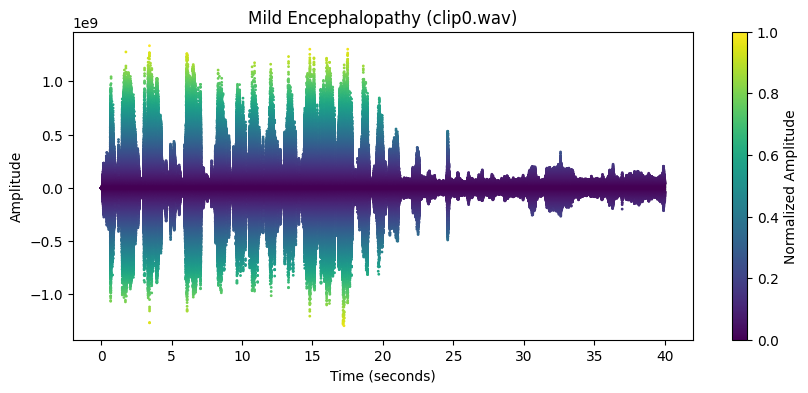

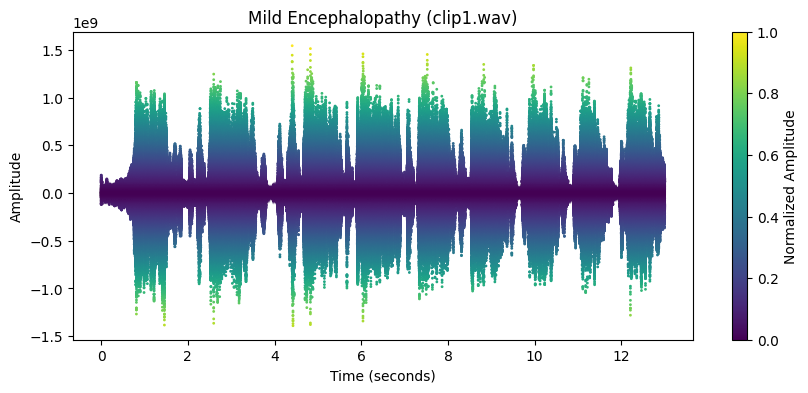

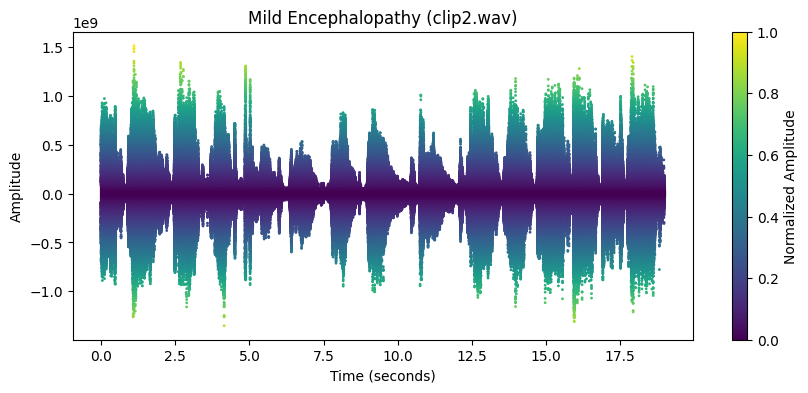

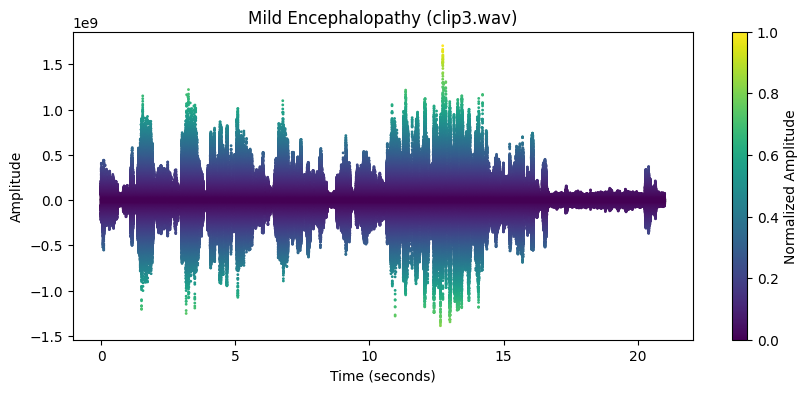

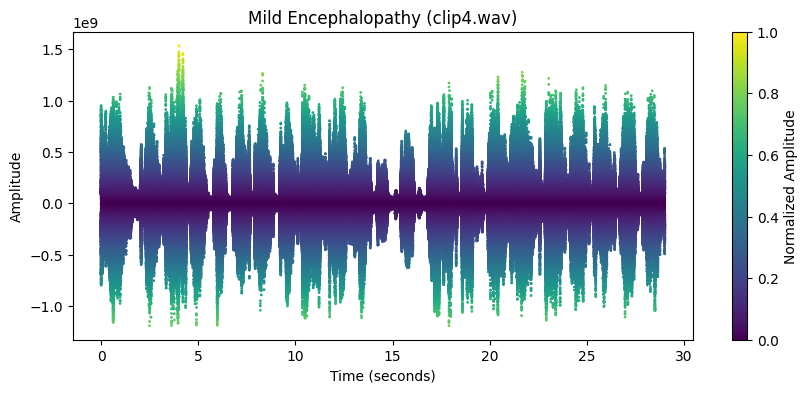

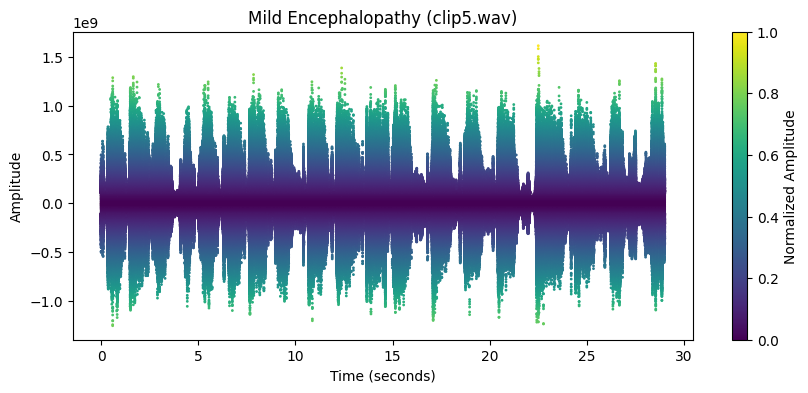

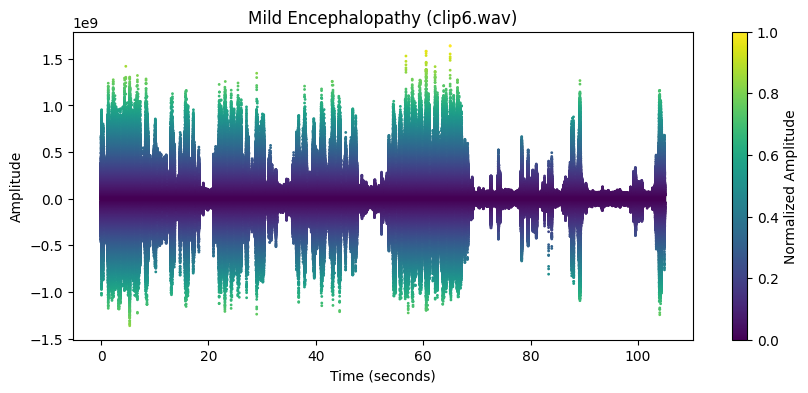

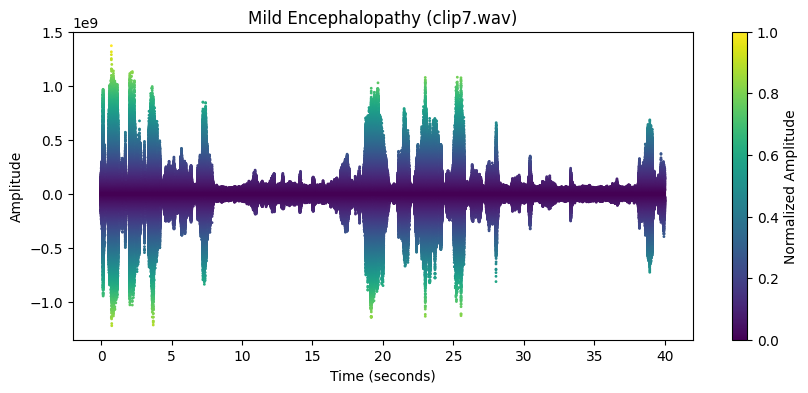

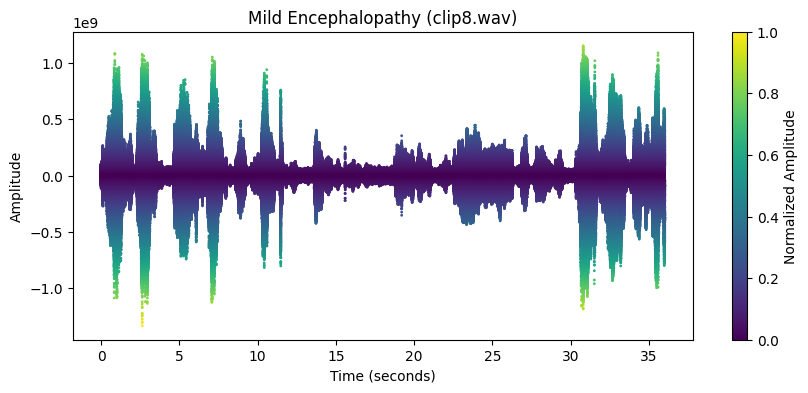

In [8]:
clips_list = ['clip0.wav', 'clip1.wav', 'clip2.wav', 'clip3.wav', 'clip4.wav', 'clip5.wav', 'clip6.wav', 'clip7.wav', 'clip8.wav']

for filename in clips_list:
    # Full path to the file
    file_path = os.path.join(clips_path, filename)
    title = f"Mild Encephalopathy ({filename})"
    plot_audio_amplitude(file_path, title)

### 4. Data set with labels
The data sets shown in this section of the notebook have been created by manually assigning labels to the data. To do this, the different audios have been played and the seconds in which the baby was crying have been noted down. Then, by means of a code, this information has been translated by creating a vector with as many values as seconds the audio had and in case the baby cries the value assigned is a 0, in case the baby does not cry the value assigned is a 1.

In [30]:
# Dataset containing labels for the audios in the Unclassified folder
unclassified_data = pd.read_csv('Unclassified_data.csv')
unclassified_data

,File_name,Labels
0,Unclassified/39ae6684-c030-4008-ba0c-05551075d...,"[1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,Unclassified/47f38257-5a56-4814-b569-54d1c2177...,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
2,Unclassified/0c84b92c-9996-4970-bece-10680196d...,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
3,Unclassified/0887b999-d13d-4234-b8ef-c28e93977...,"[1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, ..."
4,Unclassified/1181fa2b-8916-45d7-8009-ab2784701...,"[1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, ..."
5,Unclassified/2d54d51a-4e2d-4538-9cba-38dde7866...,"[1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
6,Unclassified/097e9d10-cd40-42b4-aad3-9a497eef1...,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
7,Unclassified/3aadd8c0-e7a4-48c2-b36d-0be45257a...,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, ..."
8,Unclassified/15 días sano.wav,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
9,Unclassified/19687e15-ce84-45ff-b297-868c8c86d...,"[1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [31]:
# Dataset containing labels for audios classified according to their degree of encephalopathy
test_data = pd.read_csv('Test_data.csv')
test_data

,File_name,Labels
0,Mild_encephalopathy/ARAHIP1H12082011.wav,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,Severe_encephalopathy/ARAHIP_08062011_1hora.wav,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
2,Moderate_encephalopathy/let.wav,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
3,No_encephalopathy/no_let.wav,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
4,No_encephalopathy/no_let2.wav,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."


In [27]:
#Dataset containing labels for the audios in the Mild_encephalopathy/clips folder
mild_encephalopathy_clips = pd.read_csv('Mild_encephalopathy_clips.csv')
mild_encephalopathy_clips

,File_name,Labels
0,clip0.wav,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,clip1.wav,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
2,clip2.wav,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,clip3.wav,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,clip4.wav,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
5,clip5.wav,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
6,clip6.wav,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
7,clip7.wav,"[0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, ..."
8,clip8.wav,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, ..."


In order to compare the efficiency of the models it is very important to know at which exact moments the baby is crying. In this case the manually created probabilities will be represented in order to see in a quick and visual way the seconds in which the baby cries.

**It should be noted that the values only refer to whether the baby cries or not and not to the intensity of the crying.**

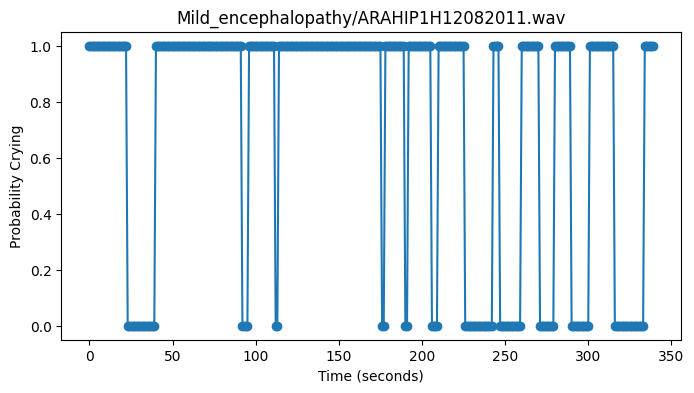

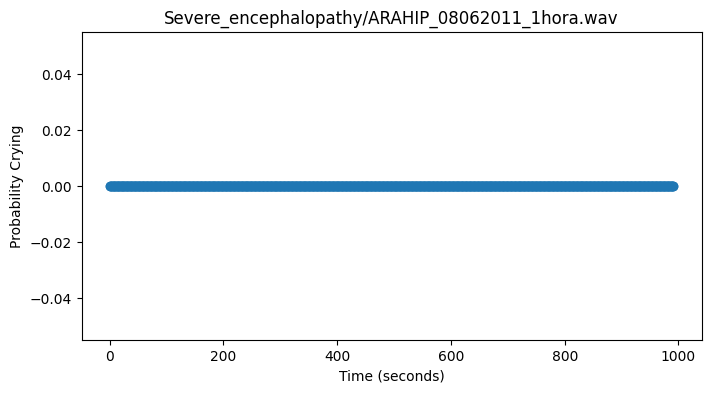

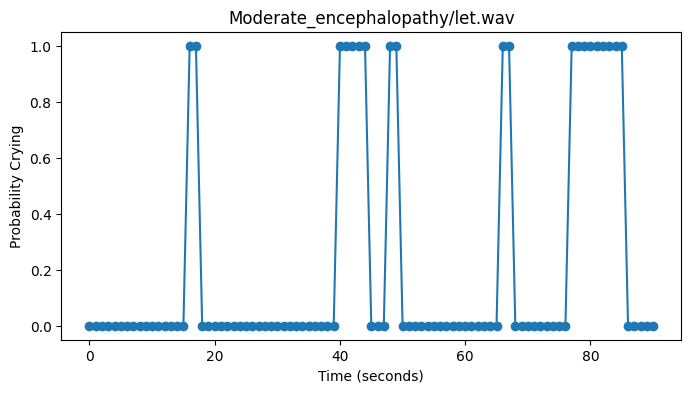

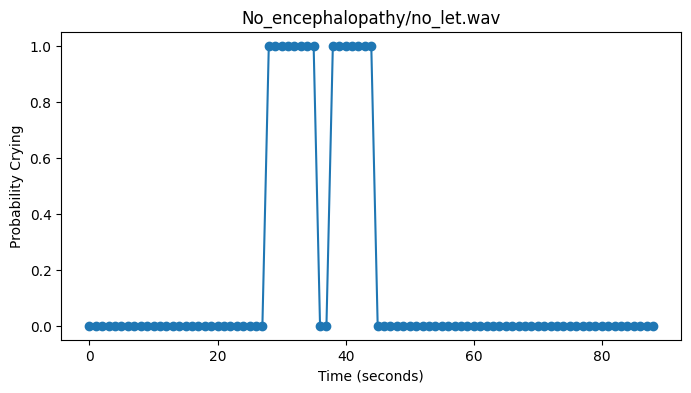

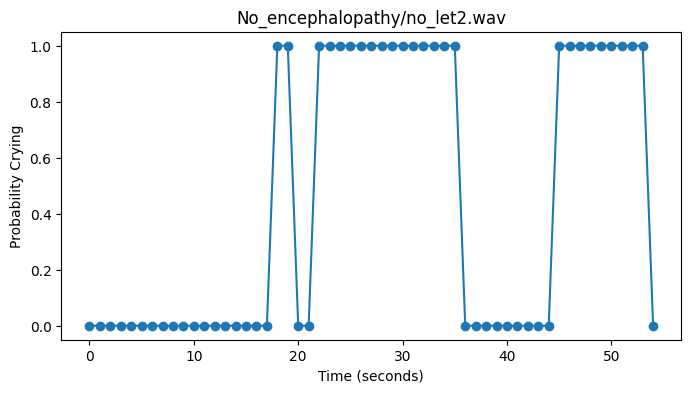

In [36]:
base_path = 'drive/MyDrive/TFM/Audios/'

def plot_labels(df):
    '''
    This function generates and saves a graph for each of the files stored in the DataFrame passed as a parameter.
    It generates a graph in which the X axis represents the time and the Y axis the probability that the value is 0 (baby cries).

    Input:
      - df (pd.DataFrame): DataFrame containing the file names and labels.
    '''
    for index, row in df.iterrows():
        # Extract filename and labels
        file_name = row['File_name']
        labels = ast.literal_eval(row['Labels'])
        labels = [int(x) for x in labels]  # Convert str to int

        # Calculate the probability of 0 at each position of the vector
        # The probability of being 0 (baby cries) is 1 (100%) if the value is 0, if the value is 1 the probability is 0 (0%)
        probabilities = [1 - value for value in labels]

        # Create the graph
        plt.figure(figsize=(8, 4))
        plt.plot(range(len(labels)), probabilities, marker='o', linestyle='-')
        plt.title(row['File_name'])
        plt.xlabel('Time (seconds)')
        plt.ylabel('Probability Crying')

        # Save the graph
        # Split path to get directories and base filename
        subdirectory, file_name = os.path.split(file_name)
        full_directory_path = os.path.join(base_path, subdirectory)
        output_filename = f"{os.path.splitext(file_name)[0]}_probability.png"
        output_path = os.path.join(full_directory_path, output_filename)
        plt.savefig(output_path)

        plt.show()

plot_labels(test_data)

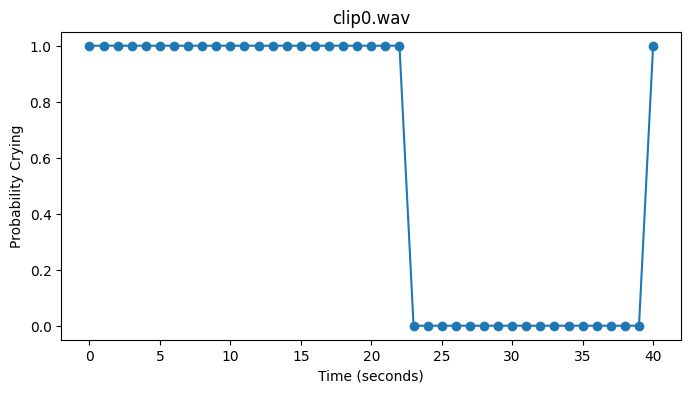

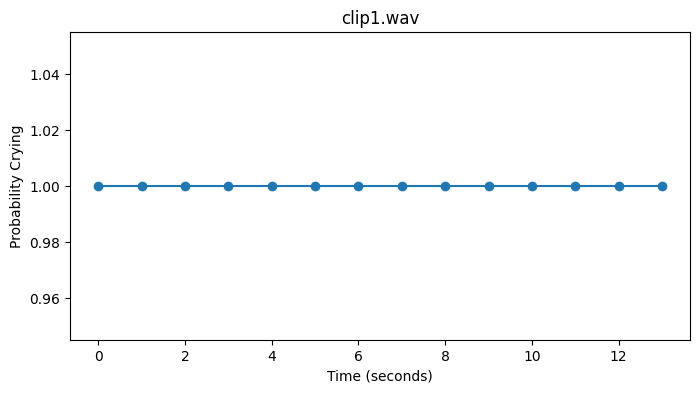

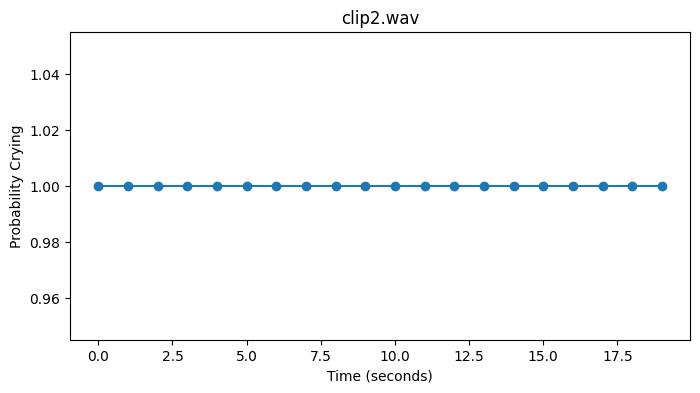

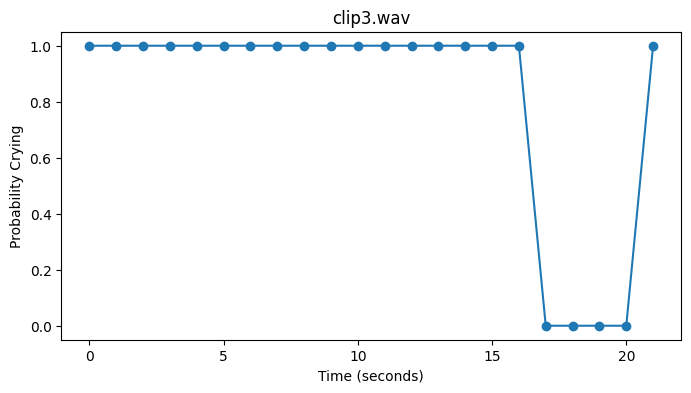

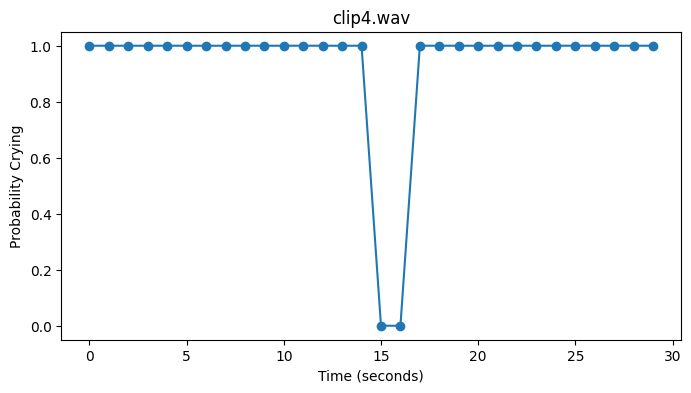

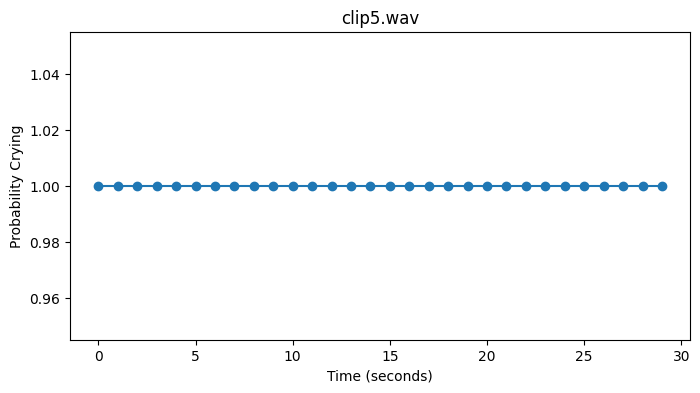

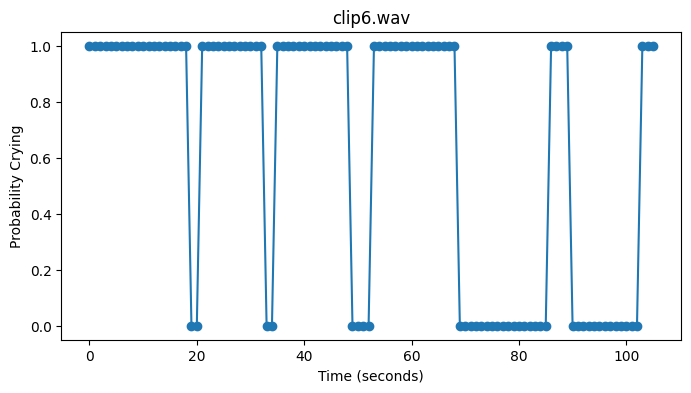

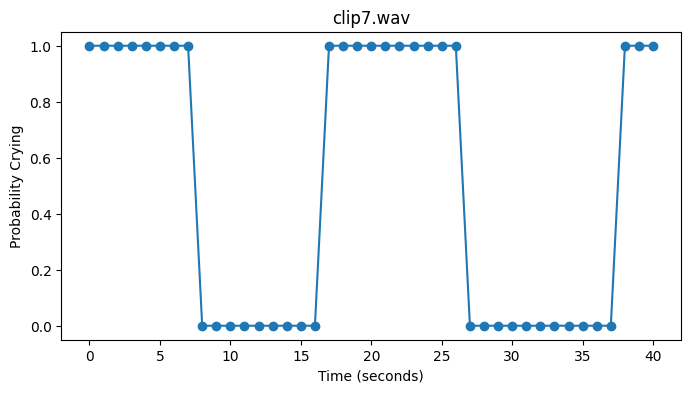

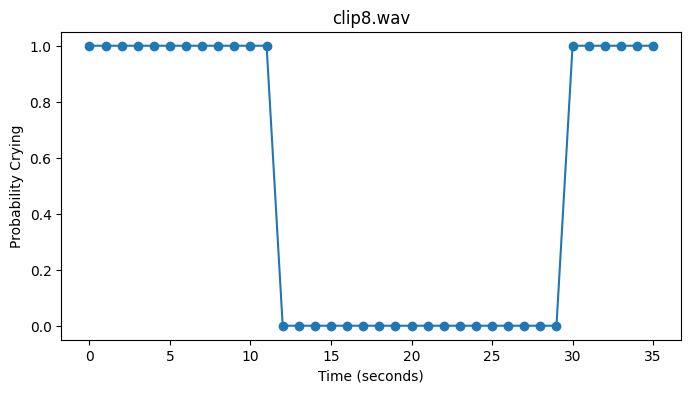

In [38]:
plot_labels(mild_encephalopathy_clips)